

---



# *Project Start*


*   Install and Import important Packages
*   Import the model
*   Transform the images
*   Generate Predicitons




# Install and Import Important Packages

In [1]:
pip install -q --no-cache-dir -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
import pickle

from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
%matplotlib inline
print('Notebook run using keras:', keras.__version__)
#display
from IPython.display import Image, display
from omegaconf import OmegaConf

Notebook run using keras: 3.5.0


# Set Directories

In [149]:
# Read pickles from the path specified in config.dest_file
config_path = "config.yaml"  # Replace with the path to your config file
config = OmegaConf.load(config_path)
folder_path = config.folder_path
path = config.path
model_path = config.model_path
csv_path = config.csv_path
output_dir = config.output_dir
output_dir = os.path.join(output_dir, 'results_weighted_average')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
shap_dir = config.shap_dir
gradcam_file = config.gradcam_file
lime_file = config.lime_file
# Load the DataFrame from the CSV file
print(folder_path, path, model_path)

C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas\image C:\Users\saadr\Desktop\data_XAI\models


In [12]:
# Define paths for your splits
train_dir = os.path.join(folder_path, 'train')
val_dir = os.path.join(folder_path, 'val')
test_dir = os.path.join(folder_path, 'test')

In [13]:
folder_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas'

# Keras Model Loading

In [14]:
#model.save(path +'./model_xception_batch16_epoch5_imgsize299.keras')
#model= loaded_model = tf.keras.models.load_model('inceptionV5_.keras')
model= loaded_model = keras.applications.Xception(weights="imagenet")

# Model Fine Tuning

In [15]:
import model.model_training_tuning as model_training_tuning
import model.model_training as model_training

In [16]:
from model.model_training_preprocessing import model_training_preprocessing
batch_size = 16
img_height = 224
img_width = 224


# Step 1: Instantiate the class
trainer = model_training_preprocessing(
    train_dir,
    val_dir,
    test_dir,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width
)

# Step 2: Load the raw datasets
train_ds, val_ds, test_ds = trainer.load_data()

# Step 3: Preprocess the datasets (with augmentation for training)
train_ds, val_ds, test_ds = trainer.preprocess_data(train_ds, val_ds, test_ds)

# Now you can use train_ds, val_ds, test_ds in model.fit(), etc.

Found 259 files belonging to 2 classes.
Number of training batches:   17
Total training samples:       272
Found 56 files belonging to 2 classes.
Number of validation batches: 4
Total validation samples:     64
Found 56 files belonging to 2 classes.
Number of test batches:       4
Total test samples:           64


# Gradcam

In [37]:
with open(gradcam_file, 'rb') as f:
	loaded_heatmap_gradcam = pickle.load(f)

In [39]:
# Option 1: Get the number of items in the list

print(len(loaded_heatmap_gradcam[1]))


224


---

# Lime

In [ ]:
with open(lime_file, 'rb') as f:
    loaded_heatmap_lime = pickle.load(f)
    
from custom_lime.LimeExplainer import LimeExplainer
lime_explainer = LimeExplainer(model, test_ds)

import pandas as pd

# Extract useful info from each explanation
lime_data = []
lime_heatmaps = []
for i, explanation in enumerate(loaded_heatmap_lime):
	# Save the top label and the explanation weights for that label
	top_label = explanation.top_labels[0]
	local_exp = explanation.local_exp[top_label]
	lime_data.append({
		"image_index": i,
		"top_label": top_label,
		"local_exp": local_exp
	})
	heatmap= lime_explainer.heatmap(explanation=explanation)
	lime_down = tf.image.resize(heatmap[..., tf.newaxis], (224, 224))
	lime_down = tf.squeeze(lime_down).numpy()

	lime_heatmaps.append(lime_down)



---


# Load Shap

In [165]:
with open(os.path.join(shap_dir), 'rb') as f:
	heatmap_shap = pickle.load(f)

In [167]:
arr = np.asarray(heatmap_shap, dtype=np.float32)  # shape N,H,W or N,H,W,1
arr.shape

(44, 224, 224)

In [160]:
import numpy as np
import tensorflow as tf

# loaded_heatmap_shap: list of 2D arrays or 3D arrays with a trailing 1 channel
import numpy as np

arr = np.asarray(loaded_heatmap_shap, dtype=np.float32)  # (44, 224, 224, 3)

# option 1 average channels
heatmap_shap = arr.mean(axis=-1)                          # (44, 224, 224)

# option 2 if channels are identical take one
# heatmap_shap = arr[..., 0]

assert heatmap_shap.shape == (44, 224, 224)



AssertionError: 

# attention Matrix


In [53]:
# prompt: load results_img_PT7_factual.csv from colab

import pandas as pd
csv_path = config.csv_path

#csv_path = "C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/data/pancreas/pancreas/attention_label/results_img_PT7_factual.csv"
# Assuming the CSV file is in your Google Drive, replace with the actual path

df = pd.read_csv(csv_path)
image_data = df.copy()
df


,Unnamed: 0,img_idx,attention,img_check,matrix_resize
0,0,pancreas_074.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
1,1,pancreas_048.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
2,2,pancreas_289.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
3,3,pancreas_262.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
4,4,pancreas_276.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
...,...,...,...,...,...
276,276,pancreas_284.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
277,277,pancreas_051.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
278,278,pancreas_045.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
279,279,pancreas_092.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"


In [55]:
df['img_check'].count()

np.int64(281)

In [56]:
import os

path_test = os.path.join(test_dir,'pos' ) # Your path to the images
filenames = []

for filename in os.listdir(path_test):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        filenames.append(filename)

print(f"Found {len(filenames)} images in the folder.")

Found 44 images in the folder.


In [57]:
df = df[df['img_idx'].isin(filenames)]


In [58]:
df['img_check'].count()

np.int64(44)

In [59]:
import ast
# Helper function to flatten and normalize a matrix
def flatten_and_normalize(matrix):
    arr = np.array(matrix).flatten()
    norm = np.linalg.norm(arr)
    if norm == 0:
        return arr
    return arr / norm

def normalize_matrix(matrix):
    arr = np.array(matrix)
    norm = np.linalg.norm(arr)
    if norm == 0:
        return arr
    return arr / norm

# Extract attention matrices from the DataFrame (assuming 'attention' column is a string of lists)
attention_matrices = []
for att in df['attention']:
    att_matrix = np.array(ast.literal_eval(att))
    attention_matrices.append(att_matrix)

---

# Preprocess the images

## Transform the images

In [60]:
images_path = path_test 

In [61]:
path_test

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test\\pos'

In [62]:
test_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [63]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import xception

# Your folder path
#folder_path = 'path/to/your/images'
target_size = (224, 224)  # Example target size for Xception
# Transform function
def transform_img_fn(images_path, target_size):
    out = []
    for img_path in images_path:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)  # Preprocessing for InceptionV3 (or any other model)
        out.append(x)
    return np.vstack(out)

# Efficient Image Loading
images = []
for filename in os.listdir(images_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        img_path = os.path.join(images_path, filename)
        # Append transformed image (processed & preprocessed)

        images.append(transform_img_fn([img_path], target_size)[0])

# Convert list to numpy array (final image dataset)
images = np.array(images)

print(f"Processed {len(images)} images.")

Processed 44 images.


In [64]:
print("Shape of images array:", images.shape)

Shape of images array: (44, 224, 224, 3)




---



# Final Heatmaps


In [168]:
heatmap_lime = lime_heatmaps
heatmap_gradcam = loaded_heatmap_gradcam
attention_matrices = attention_matrices
heatmap_shap = heatmap_shap

In [169]:
len(attention_matrices[0]), len(heatmap_gradcam[0]), len(heatmap_lime[0]), len(heatmap_shap[0])

(224, 224, 224, 224)

In [172]:
avg_heatmap = (0.3*np.array(heatmap_gradcam) + 0.5*np.array(heatmap_lime) + 0.2*np.array(heatmap_shap)) / 3
ensemble_map = avg_heatmap


In [173]:
def normalize_matrix(hm):
    hm = np.array(hm, dtype=np.float32)
    hm -= np.min(hm)          # shift min to 0
    hm /= (np.max(hm) + 1e-8) # scale max to 1
    return hm

n = len(df)
gradcam_vectors = [normalize_matrix(hm) for hm in heatmap_gradcam]
lime_vectors = [normalize_matrix(hm) for hm in heatmap_lime]
avg_heatmap= [normalize_matrix(hm) for hm in avg_heatmap]
shap_vectors = [normalize_matrix(hm) for hm in heatmap_shap]
attention_matrices = [normalize_matrix(hm) for hm in attention_matrices]
ensemble_map = [normalize_matrix(hm) for hm in ensemble_map]




#print the min and max of each vector to check normalization
print("Grad-CAM vectors min/max:", np.min(gradcam_vectors), np.max(gradcam_vectors))
print("LIME vectors min/max:", np.min(lime_vectors), np.max(lime_vectors))
print("Avg heatmap min/max:", np.min(avg_heatmap), np.max(avg_heatmap))
print("Shap vectors min/max:", np.min(shap_vectors), np.max(shap_vectors))
print("Attention matrices min/max:", np.min(attention_matrices), np.max(attention_matrices))
print("Ensemble map min/max:", np.min(ensemble_map), np.max(ensemble_map))


Grad-CAM vectors min/max: 0.0 1.0
LIME vectors min/max: 0.0 1.0
Avg heatmap min/max: 0.0 0.99999994
Shap vectors min/max: 0.0 0.0
Attention matrices min/max: 0.0 1.0
Ensemble map min/max: 0.0 0.99999994


# Benchmarks

### Average

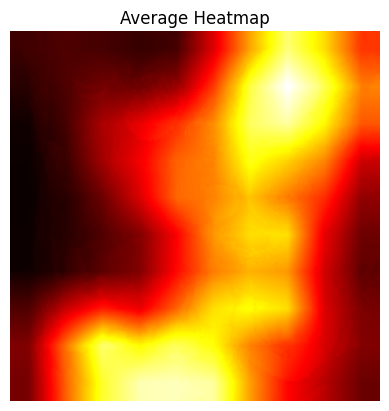

In [121]:
# Example: average the first heatmap from each method
#avg_heatmap = (gradcam_vectors + lime_vectors) / 2

import matplotlib.pyplot as plt
plt.imshow(avg_heatmap[1], cmap='hot')
plt.title("Average Heatmap")
plt.axis('off')
plt.show()

## Decision Impact Ratio

In [174]:
#decision impact ratio

def decision_impact_ratio(heatmap, threshold=0.5):
    """
    Calculate the decision impact ratio based on a heatmap.
    
    Parameters:
    - heatmap: 2D numpy array representing the heatmap.
    - threshold: float, threshold to determine significant regions.
    
    Returns:
    - ratio: float, the ratio of significant regions to total area.
    """
    # Binarize the heatmap based on the threshold
    binary_heatmap = (heatmap >= threshold).astype(int)
    
    # Calculate the area of significant regions
    significant_area = np.sum(binary_heatmap)
    
    # Calculate the total area of the heatmap
    total_area = heatmap.size
    
    # Calculate the decision impact ratio
    ratio = significant_area / total_area
    
    return ratio

# Example usage
n = min(len(df), len(gradcam_vectors), len(lime_vectors), len(attention_matrices), len(shap_vectors), len(ensemble_map))
di_gradcam = []
di_lime=[]
di_shap=[]
di_attention = []
di_ensemble = []
di_avg = []
threshold = 0.17
for i in range(n):
    att_vec = attention_matrices[i].reshape(1, -1)
    gradcam_vec = gradcam_vectors[i].reshape(1, -1)
    lime_vec = lime_vectors[i].reshape(1, -1)
    shap_vec = shap_vectors[i].reshape(1, -1)
    ensemble_vec = ensemble_map[i].reshape(1, -1)
    avg_vec = avg_heatmap[i].reshape(1, -1)

    di_gradcam.append(decision_impact_ratio(gradcam_vec, threshold=threshold))
    di_lime.append(decision_impact_ratio(lime_vec, threshold=threshold))
    di_shap.append(decision_impact_ratio(shap_vec, threshold=threshold))
    di_attention.append(decision_impact_ratio(att_vec, threshold=threshold))
    di_ensemble.append(decision_impact_ratio(ensemble_vec, threshold=threshold))
    di_avg.append(decision_impact_ratio(avg_vec, threshold=threshold))

# Store the results in the DataFrame
di_df = pd.DataFrame({
    'img_idx': df['img_idx'].values[:n],
    'di_gradcam': di_gradcam,
    'di_lime': di_lime,
    'di_shap': di_shap,
    'di_attention': di_attention,
    'di_ensemble': di_ensemble,
    'di_avg': di_avg
})

# Save to CSV
di_df.to_csv(output_dir + f'/decision_impact_ratios_{threshold}.csv', index=False)


di_df[['di_gradcam','di_lime',"di_shap",'di_ensemble', 'di_avg']].mean(), di_df[['di_gradcam','di_lime',"di_shap", 'di_ensemble', 'di_avg']].std()


(di_gradcam     0.531574
 di_lime        0.968058
 di_shap        0.000000
 di_ensemble    0.579717
 di_avg         0.579717
 dtype: float64,
 di_gradcam     0.192213
 di_lime        0.031241
 di_shap        0.000000
 di_ensemble    0.203697
 di_avg         0.203697
 dtype: float64)

In [123]:
heatmap_lime= lime_heatmaps
heatmap_gradcam = loaded_heatmap_gradcam
n = len(df)


In [124]:
print(att_vec.shape, gradcam_vec.shape, lime_vec.shape, shap_vec.shape, ensemble_vec.shape, avg_vec.shape)

(1, 50176) (1, 50176) (1, 50176) (1, 50176) (1, 50176) (1, 50176)


In [125]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Flatten the heatmaps
gradcam_flat = gradcam_vectors
lime_flat = lime_vectors
attention_flat = attention_matrices
shap_vectors = shap_vectors
ensemble_map = ensemble_map


# Compute cosine similarity for each image and each method
cosine_sim_gradcam = []
cosine_sim_lime = []
cosine_sim_shap = []
cosine_sim_ensemble = []

n = min(len(df), len(gradcam_vectors), len(lime_vectors), len(attention_matrices), len(shap_vectors), len(ensemble_map))

for i in range(n):
    att_vec = attention_matrices[i].reshape(1, -1)
    gradcam_vec = gradcam_vectors[i].reshape(1, -1)
    lime_vec = lime_vectors[i].reshape(1, -1)
    shap_vec = shap_vectors[i].reshape(1, -1)
    ensemble_vec = ensemble_map[i].reshape(1, -1)
    cosine_sim_gradcam.append(cosine_similarity(att_vec, gradcam_vec)[0, 0])
    cosine_sim_lime.append(cosine_similarity(att_vec, lime_vec)[0, 0])
    cosine_sim_shap.append(cosine_similarity(att_vec, shap_vec)[0, 0])
    cosine_sim_ensemble.append(cosine_similarity(att_vec, ensemble_vec)[0, 0])

# Results as DataFrame for easy viewing
cosine_df = pd.DataFrame({
    'img_idx': df['img_idx'].values,
    'cosine_gradcam': cosine_sim_gradcam,
    'cosine_lime': cosine_sim_lime,
     'cosine_shap': cosine_sim_shap,
    'cosine_ensemble': cosine_sim_ensemble
})

#print(cosine_df)

#cosine_df.to_csv(output_dir+'\cosine_similarity_results.csv', index=False)

import pandas as pd
df = cosine_df  # or use your DataFrame

# Average similarity
avg_gradcam = df['cosine_gradcam'].mean()
avg_lime = df['cosine_lime'].mean()
avg_shap = df['cosine_shap'].mean()
avg_avg = df['cosine_gradcam'].mean()
avg_ensemble = df['cosine_ensemble'].mean()

print("Average Cosine Similarity:")
print(f"Grad-CAM: {avg_gradcam:.3f}")
print(f"LIME: {avg_lime:.3f}")
print(f"Shap: {avg_shap:.3f}")
print(f"Ensemble: {avg_ensemble:.3f}")




cosine_df.to_csv(output_dir+'\cosine_similarity_results.csv', index=False)


Average Cosine Similarity:
Grad-CAM: 0.087
LIME: 0.139
Shap: 0.000
Ensemble: 0.092


# Localization effectiveness


## accordance recall

In [126]:
#accordance recall form df and heatmaps

def accordance_recall(attention_vector, heatmap, threshold=0.5):
    """
    Calculate the accordance recall for each heatmap based on a threshold.
    
    Parameters:
    - attention_vector: vector containing 'attention' values.
    - heatmaps: List of 2D numpy arrays representing the heatmaps.
    - threshold: float, threshold to determine significant regions.
    
    Returns:
    - recall_scores: List of recall scores for each heatmap.
    """
    
        
    # Binarize both vectors based on the threshold
    attention_binary = (attention_vector >= threshold).astype(int)
    heatmap_binary = (heatmap >= threshold).astype(int)
    
    # Calculate true positives and false negatives
    true_positives = np.sum(attention_binary * heatmap_binary)
    false_negatives = np.sum(attention_binary) - true_positives
    
    # Calculate recall
    if (true_positives + false_negatives) == 0:
        recall = 0.0
    else:
        recall = true_positives / (true_positives + false_negatives)
    
    recall
    
    return recall
import numpy as np

def accordance_recall_adaptive(attention_vector, heatmap, percentile=80):
    """
    Calculate the accordance recall for each heatmap based on a percentile-based adaptive threshold.
    
    Parameters:
    - attention_vector: 1D numpy array containing 'attention' values.
    - heatmap: 1D numpy array representing the heatmap.
    - percentile: float, percentile to determine threshold (e.g., 80 means top 20% pixels are important).
    
    Returns:
    - recall: float, recall score.
    """
    # Flatten the vectors just in case
    attention_vector = attention_vector.flatten()
    heatmap = heatmap.flatten()
    
    # Adaptive thresholds based on percentile
    threshold_att = np.percentile(attention_vector, percentile)
    threshold_hm = np.percentile(heatmap, percentile)
    
    # Binarize both vectors
    attention_binary = (attention_vector >= threshold_att).astype(int)
    heatmap_binary = (heatmap >= threshold_hm).astype(int)
    
    # Calculate true positives and false negatives
    true_positives = np.sum(attention_binary * heatmap_binary)
    false_negatives = np.sum(attention_binary) - true_positives
    
    # Calculate recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    
    return recall


# Example usage
n = min(len(df), len(gradcam_vectors), len(lime_vectors), len(attention_matrices), len(shap_vectors), len(ensemble_map))
recall_gradcam = []
recall_lime=[]
recall_shap=[]
recall_attention = []
recall_ensemble = []
threshold = 0.2

for i in range(n):
    att_vec = attention_matrices[i].reshape(1, -1)
    gradcam_vec = gradcam_vectors[i].reshape(1, -1)
    lime_vec = lime_vectors[i].reshape(1, -1)
    shap_vec = shap_vectors[i].reshape(1, -1)
    ensemble_vec = ensemble_map[i].reshape(1, -1)

    recall_gradcam.append(accordance_recall(att_vec, gradcam_vec, threshold=threshold))
    recall_lime.append(accordance_recall(att_vec, lime_vec, threshold=threshold))
    recall_shap.append(accordance_recall(att_vec,shap_vec, threshold=threshold))
    recall_attention.append(accordance_recall(att_vec, att_vec,threshold=threshold))
    recall_ensemble.append(accordance_recall(att_vec,ensemble_vec, threshold=threshold))

# Store the results in the DataFrame
recall_df = pd.DataFrame({
    'img_idx': df['img_idx'].values[:n],
    'recall_gradcam': recall_gradcam,
    'recall_lime': recall_lime,
    'recall_shap': recall_shap,
    'recall_attention': recall_attention,
    'recall_ensemble': recall_ensemble
})
#print(recall_df)
# Save to CSV
recall_df.to_csv(output_dir + f'/recall_ratios_{threshold}.csv', index=False)


recall_df[[ "recall_gradcam","recall_lime","recall_shap",'recall_ensemble']].mean(), recall_df[['recall_gradcam','recall_lime','recall_ensemble']].std()
    #'di_gradcam','di_lime',"di_average_lime_gradcam",'di_ensemble']].mean(), recall_df[['di_gradcam','recall_lime','recall_ensemble']].std()


(recall_gradcam     0.380667
 recall_lime        0.962451
 recall_shap        0.000000
 recall_ensemble    0.426423
 dtype: float64,
 recall_gradcam     0.409431
 recall_lime        0.082262
 recall_ensemble    0.414070
 dtype: float64)

In [127]:
import numpy as np

def accordance_recall_adaptive(attention_vector, heatmap, percentile=80):
    """
    Calculate the accordance recall for each heatmap based on a percentile-based adaptive threshold.
    
    Parameters:
    - attention_vector: 1D numpy array containing 'attention' values.
    - heatmap: 1D numpy array representing the heatmap.
    - percentile: float, percentile to determine threshold (e.g., 80 means top 20% pixels are important).
    
    Returns:
    - recall: float, recall score.
    """
    # Flatten the vectors just in case
    attention_vector = attention_vector.flatten()
    heatmap = heatmap.flatten()
    
    # Adaptive thresholds based on percentile
    threshold_att = np.percentile(attention_vector, percentile)
    threshold_hm = np.percentile(heatmap, percentile)
    
    # Binarize both vectors
    attention_binary = (attention_vector >= threshold_att).astype(int)
    heatmap_binary = (heatmap >= threshold_hm).astype(int)
    
    # Calculate true positives and false negatives
    true_positives = np.sum(attention_binary * heatmap_binary)
    false_negatives = np.sum(attention_binary) - true_positives
    
    # Calculate recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    
    return recall


recall_gradcam = []
recall_lime = []
recall_shap = []
recall_attention = []
recall_ensemble = []

n = min(len(df), len(gradcam_vectors), len(lime_vectors), len(attention_matrices), len(shap_vectors), len(ensemble_map))

for i in range(n):
    att_vec = attention_matrices[i].reshape(-1)
    gradcam_vec = gradcam_vectors[i].reshape(-1)
    lime_vec = lime_vectors[i].reshape(-1)
    shap_vec = shap_vectors[i].reshape(-1)
    ensemble_vec = ensemble_map[i].reshape(-1)

    recall_gradcam.append(accordance_recall_adaptive(att_vec, gradcam_vec, percentile=80))
    recall_lime.append(accordance_recall_adaptive(att_vec, lime_vec, percentile=80))
    recall_shap.append(accordance_recall_adaptive(att_vec, shap_vec, percentile=80))
    recall_attention.append(accordance_recall_adaptive(att_vec, att_vec, percentile=80))
    recall_ensemble.append(accordance_recall_adaptive(att_vec, ensemble_vec, percentile=80))

# Create DataFrame
recall_df = pd.DataFrame({
    'img_idx': df['img_idx'].values[:n],
    'recall_gradcam': recall_gradcam,
    'recall_lime': recall_lime,
    'recall_shap': recall_shap,
    'recall_attention': recall_attention,
    'recall_ensemble': recall_ensemble
})

# print(recall_df)
recall_df[[ "recall_gradcam","recall_lime","recall_shap",'recall_ensemble']].mean(), recall_df[['recall_gradcam','recall_lime','recall_ensemble']].std()


(recall_gradcam     0.200047
 recall_lime        0.201894
 recall_shap        1.000000
 recall_ensemble    0.200023
 dtype: float64,
 recall_gradcam     0.000061
 recall_lime        0.002546
 recall_ensemble    0.000029
 dtype: float64)

In [128]:
import numpy as np

def flatten_and_normalize(matrix):
    """Flatten a 2D matrix to 1D and normalize to [0,1]."""
    flat = matrix
    if flat.max() > flat.min():  # Avoid division by zero
        flat = (flat - flat.min()) / (flat.max() - flat.min())
    else:
        flat = np.zeros_like(flat)
    return flat

def soft_accordance_precision(attention_vector, heatmap_vector):
    """
    Compute soft precision between attention and heatmap vectors.
    No thresholding; values are continuous [0,1].
    """
    attention_vector = attention_vector / (attention_vector.sum() + 1e-8)
    heatmap_vector = heatmap_vector / (heatmap_vector.sum() + 1e-8)
    precision = np.sum(attention_vector * heatmap_vector)
    return precision

def compute_precisions(attention_matrices, heatmaps_dict):
    """
    Compute soft precision for multiple XAI methods.
    
    Parameters:
    - attention_matrices: list of np.arrays (attention for each image)
    - heatmaps_dict: dict of {method_name: list_of_heatmaps_for_each_image}
    
    Returns:
    - dict of {method_name: list_of_precisions_per_image}
    """
    precisions = {method: [] for method in heatmaps_dict.keys()}
    n = len(attention_matrices)
    
    for i in range(n):
        att_vec = (attention_matrices[i])
        for method, heatmaps in heatmaps_dict.items():
            heat_vec = (heatmaps[i])
            precisions[method].append(soft_accordance_precision(att_vec, heat_vec))
    
    return precisions

heatmaps_dict = {
    'gradcam': gradcam_vec,
    'lime': lime_vec,
    'shap': shap_vec,
    'ensemble': att_vec  # or your average/weighted map
}

precisions = compute_precisions(att_vec, heatmaps_dict)

# Example: mean precision per method
for method, scores in precisions.items():
    print(f"{method}: mean precision = {np.mean(scores):.3f}")


gradcam: mean precision = 0.009
lime: mean precision = 0.009
shap: mean precision = 0.000
ensemble: mean precision = 0.009


---

# Weighted 

In [129]:
import numpy as np
from typing import Tuple, Dict, Any, Optional
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score

def _normalize01(img: np.ndarray, q: float = 99.0) -> np.ndarray:
    """Percentile based normalization to [0, 1] for a single map."""
    m = np.percentile(img, q)
    m = max(m, 1e-8)
    x = np.clip(img / m, 0.0, 1.0)
    return x.astype(np.float32)

def _prep_single_image(G: np.ndarray, L: np.ndarray, S: np.ndarray, stride: int) -> Tuple[np.ndarray, np.ndarray]:
    """Normalize each map per image, then optionally thin the grid by stride."""
    Gn = _normalize01(G)
    Ln = _normalize01(L)
    Sn = _normalize01(S)
    if stride > 1:
        Gn = Gn[::stride, ::stride]
        Ln = Ln[::stride, ::stride]
        Sn = Sn[::stride, ::stride]
    X = np.stack([Gn, Ln, Sn], axis=-1).reshape(-1, 3)
    return X, Gn

def build_dataset(
    G: np.ndarray,
    L: np.ndarray,
    S: np.ndarray,
    M: np.ndarray,
    stride: int = 4
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Tuple[int, int]]:
    """
    Build per pixel dataset from heatmaps and masks.
    G, L, S, M have shape [N, H, W].
    Returns X, y, groups, and the downsampled shape as (h, w).
    """
    assert G.shape == L.shape == S.shape == M.shape, "Input arrays must have the same shape"
    N, H, W = G.shape
    X_list = []
    y_list = []
    groups = []
    for i in range(N):
        Xi, _ = _prep_single_image(G[i], L[i], S[i], stride)
        if stride > 1:
            Mi = M[i][::stride, ::stride].reshape(-1).astype(np.uint8)
        else:
            Mi = M[i].reshape(-1).astype(np.uint8)
        X_list.append(Xi)
        y_list.append(Mi)
        groups.append(np.full(Xi.shape[0], i, dtype=np.int32))
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    groups = np.concatenate(groups, axis=0)
    h = H // stride if stride > 1 else H
    w = W // stride if stride > 1 else W
    return X, y, groups, (h, w)

def fit_logistic_stacker(
    G: np.ndarray,
    L: np.ndarray,
    S: np.ndarray,
    M: np.ndarray,
    stride: int = 4,
    C: float = 1.0,
    max_iter: int = 200,
    n_splits: int = 5,
    class_weight: str = "balanced",
    random_state: int = 0
) -> Dict[str, Any]:
    """
    Train a pixel level logistic stacker with group cross validation by image.
    Returns a dict with the final model, OOF metrics, chosen threshold, and utilities.
    """
    X, y, groups, shape_ds = build_dataset(G, L, S, M, stride=stride)

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LogisticRegression(
            penalty="l2",
            C=C,
            max_iter=max_iter,
            class_weight=class_weight,
            solver="liblinear",
            random_state=random_state,
        )),
    ])

    gkf = GroupKFold(n_splits=n_splits)
    oof_pred = np.zeros_like(y, dtype=np.float32)

    for train_idx, valid_idx in gkf.split(X, y, groups):
        Xtr, Xva = X[train_idx], X[valid_idx]
        ytr = y[train_idx]
        pipe.fit(Xtr, ytr)
        p = pipe.predict_proba(Xva)[:, 1]
        oof_pred[valid_idx] = p.astype(np.float32)

    thr_grid = np.linspace(0.05, 0.95, 19)
    f1_vals = [f1_score(y, oof_pred >= t) for t in thr_grid]
    best_idx = int(np.argmax(f1_vals))
    best_thr = float(thr_grid[best_idx])

    pipe.fit(X, y)

    f1 = f1_score(y, oof_pred >= best_thr)
    prec = precision_score(y, oof_pred >= best_thr, zero_division=0)
    rec = recall_score(y, oof_pred >= best_thr)

    return {
        "model": pipe,
        "stride": stride,
        "shape_ds": shape_ds,
        "threshold": best_thr,
        "oof_pred": oof_pred,
        "oof_metrics": {"f1": float(f1), "precision": float(prec), "recall": float(rec)},
    }

def predict_full_maps(
    model_pack: Dict[str, Any],
    G: np.ndarray,
    L: np.ndarray,
    S: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Predict fused probability maps and binary masks at full size.
    Returns prob maps of shape [N, H, W] and binary masks with the same shape.
    """
    pipe = model_pack["model"]
    stride = model_pack["stride"]
    thr = model_pack["threshold"]
    N, H, W = G.shape
    prob_maps = np.zeros_like(G, dtype=np.float32)

    for i in range(N):
        X_i, Gn = _prep_single_image(G[i], L[i], S[i], stride)
        p = pipe.predict_proba(X_i)[:, 1].reshape(Gn.shape[0], Gn.shape[1])
        if stride > 1:
            prob_maps[i] = _bilinear_upsample(p, (H, W))
        else:
            prob_maps[i] = p

    bin_maps = (prob_maps >= thr).astype(np.uint8)
    return prob_maps, bin_maps

def _bilinear_upsample(arr: np.ndarray, out_hw: Tuple[int, int]) -> np.ndarray:
    """Simple bilinear upsample using NumPy operations. Avoids external deps."""
    in_h, in_w = arr.shape
    out_h, out_w = out_hw
    scale_y = (in_h - 1) / max(out_h - 1, 1)
    scale_x = (in_w - 1) / max(out_w - 1, 1)
    yy = np.arange(out_h) * scale_y
    xx = np.arange(out_w) * scale_x
    y0 = np.floor(yy).astype(int)
    x0 = np.floor(xx).astype(int)
    y1 = np.clip(y0 + 1, 0, in_h - 1)
    x1 = np.clip(x0 + 1, 0, in_w - 1)
    wy = yy - y0
    wx = xx - x0

    Ia = arr[y0[:, None], x0[None, :]]
    Ib = arr[y1[:, None], x0[None, :]]
    Ic = arr[y0[:, None], x1[None, :]]
    Id = arr[y1[:, None], x1[None, :]]

    wa = (1 - wy)[:, None] * (1 - wx)[None, :]
    wb = wy[:, None] * (1 - wx)[None, :]
    wc = (1 - wy)[:, None] * wx[None, :]
    wd = wy[:, None] * wx[None, :]

    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out.astype(np.float32)

def evaluate_against_masks(
    prob_maps: np.ndarray,
    bin_maps: np.ndarray,
    masks: np.ndarray
) -> Dict[str, float]:
    """Compute set level F1, precision, recall, and mean IoU versus binary masks."""
    assert prob_maps.shape == masks.shape == bin_maps.shape
    eps = 1e-8
    N = masks.shape[0]
    iou_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    for i in range(N):
        y_true = masks[i].astype(np.uint8).reshape(-1)
        y_pred = bin_maps[i].astype(np.uint8).reshape(-1)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        iou = tp / (tp + fp + fn + eps)
        f1 = 2 * tp / (2 * tp + fp + fn + eps)
        prec = tp / (tp + fp + eps) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn + eps) if (tp + fn) > 0 else 0.0
        iou_list.append(iou)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
    return {
        "mean_iou": float(np.mean(iou_list)),
        "mean_f1": float(np.mean(f1_list)),
        "mean_precision": float(np.mean(prec_list)),
        "mean_recall": float(np.mean(rec_list)),
    }

def fuse_weighted_mean(G: np.ndarray, L: np.ndarray, S: np.ndarray, w: Tuple[float, float, float]) -> np.ndarray:
    """Per image percentile normalization then weighted mean, returns prob maps in [0,1]."""
    N, H, W = G.shape
    out = np.zeros_like(G, dtype=np.float32)
    w = np.array(w, dtype=np.float32)
    w = w / np.sum(w)
    for i in range(N):
        Gn = _normalize01(G[i])
        Ln = _normalize01(L[i])
        Sn = _normalize01(S[i])
        out[i] = w[0]*Gn + w[1]*Ln + w[2]*Sn
        out[i] = np.clip(out[i], 0.0, 1.0)
    return out

def fuse_effect_size(G: np.ndarray, L: np.ndarray, S: np.ndarray, lam: float = 1e-6) -> np.ndarray:
    """Mean over methods divided by the standard deviation, with small lambda for stability."""
    N, H, W = G.shape
    out = np.zeros_like(G, dtype=np.float32)
    for i in range(N):
        Gn = _normalize01(G[i])
        Ln = _normalize01(L[i])
        Sn = _normalize01(S[i])
        stack = np.stack([Gn, Ln, Sn], axis=0)
        M = np.mean(stack, axis=0)
        V = np.var(stack, axis=0)
        E = M / np.sqrt(V + lam)
        E = np.clip(E, 0.0, None)
        E = _normalize01(E, q=99.0)
        out[i] = E
    return out


In [130]:
import numpy as np
#from xai_ensemble_stacker import fit_logistic_stacker, predict_full_maps, evaluate_against_masks, fuse_weighted_mean, fuse_effect_size

G = np.array(heatmap_gradcam)  # Grad-CAM maps
L = np.array(heatmap_lime)   # LIME maps
S = np.array(heatmap_shap)   # SHAP maps
M = np.array(attention_matrices)
#are arrays shaped [N, 224, 224]
# M is binary in {0,1}

model = fit_logistic_stacker(G, L, S, M, stride=4, C=1.0, max_iter=200, n_splits=5)
prob_maps, bin_maps = predict_full_maps(model, G, L, S)
print("OOF:", model["oof_metrics"])
print("Test:", evaluate_against_masks(prob_maps, bin_maps, M))

# Baselines
wm = fuse_weighted_mean(G, L, S, w=(0.134, 0.661, 0.204))  # prob maps
es = fuse_effect_size(G, L, S)  # prob maps


OOF: {'f1': 0.0559929772435681, 'precision': 0.029330616749437582, 'recall': 0.6154988123515439}
Test: {'mean_iou': 0.02940752063844806, 'mean_f1': 0.05443840714711829, 'mean_precision': 0.029923880647569057, 'mean_recall': 0.6219341360768396}


In [131]:
import numpy as np
from typing import Tuple, Dict, Any, Sequence
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def _normalize01(img: np.ndarray, q: float = 99.0) -> np.ndarray:
    m = np.percentile(img, q)
    m = max(m, 1e-8)
    x = np.clip(img / m, 0.0, 1.0)
    return x.astype(np.float32)

def _image_features(G: np.ndarray, L: np.ndarray, S: np.ndarray, stride: int, lam: float = 1e-6) -> Tuple[np.ndarray, Tuple[int,int]]:
    Gn = _normalize01(G)[::stride, ::stride] if stride > 1 else _normalize01(G)
    Ln = _normalize01(L)[::stride, ::stride] if stride > 1 else _normalize01(L)
    Sn = _normalize01(S)[::stride, ::stride] if stride > 1 else _normalize01(S)
    stack = np.stack([Gn, Ln, Sn], axis=0)
    M = np.mean(stack, axis=0)
    V = np.var(stack, axis=0)
    E = M / np.sqrt(V + lam)
    E = np.clip(E, 0.0, None)
    X = np.stack([Gn, Ln, Sn, M, V, E], axis=-1).reshape(-1, 6)
    return X, Gn.shape

def _bilinear_upsample(arr: np.ndarray, out_hw: Tuple[int, int]) -> np.ndarray:
    in_h, in_w = arr.shape
    out_h, out_w = out_hw
    if in_h == out_h and in_w == out_w:
        return arr.astype(np.float32)
    sy = (in_h - 1) / max(out_h - 1, 1)
    sx = (in_w - 1) / max(out_w - 1, 1)
    yy = np.arange(out_h) * sy
    xx = np.arange(out_w) * sx
    y0 = np.floor(yy).astype(int)
    x0 = np.floor(xx).astype(int)
    y1 = np.clip(y0 + 1, 0, in_h - 1)
    x1 = np.clip(x0 + 1, 0, in_w - 1)
    wy = yy - y0
    wx = xx - x0
    Ia = arr[y0[:, None], x0[None, :]]
    Ib = arr[y1[:, None], x0[None, :]]
    Ic = arr[y0[:, None], x1[None, :]]
    Id = arr[y1[:, None], x1[None, :]]
    wa = (1 - wy)[:, None] * (1 - wx)[None, :]
    wb = wy[:, None] * (1 - wx)[None, :]
    wc = (1 - wy)[:, None] * wx[None, :]
    wd = wy[:, None] * wx[None, :]
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out.astype(np.float32)

def build_dataset_advanced(
    G: np.ndarray, L: np.ndarray, S: np.ndarray, M: np.ndarray,
    stride: int = 4, neg_ratio: int = 3, seed: int = 0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert G.shape == L.shape == S.shape == M.shape
    rng = np.random.RandomState(seed)
    X_list, y_list, groups = [], [], []
    N, H, W = G.shape
    for i in range(N):
        Xi, shp = _image_features(G[i], L[i], S[i], stride)
        Mi = M[i][::stride, ::stride] if stride > 1 else M[i]
        yi = Mi.reshape(-1).astype(np.uint8)

        pos_idx = np.flatnonzero(yi == 1)
        neg_idx = np.flatnonzero(yi == 0)
        if len(pos_idx) == 0:
            # keep a small random subset of negatives so the image contributes
            keep_neg = rng.choice(neg_idx, size=min(2000, len(neg_idx)), replace=False)
            keep = keep_neg
        else:
            k_neg = min(len(neg_idx), neg_ratio * len(pos_idx))
            keep_neg = rng.choice(neg_idx, size=k_neg, replace=False)
            keep = np.concatenate([pos_idx, keep_neg])

        X_list.append(Xi[keep])
        y_list.append(yi[keep])
        groups.append(np.full(keep.shape[0], i, dtype=np.int32))

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    groups = np.concatenate(groups, axis=0)
    return X, y, groups

def _metric_from_counts(tp, fp, fn, metric: str, beta: float) -> float:
    if metric == "iou":
        denom = tp + fp + fn
        return tp / denom if denom > 0 else 0.0
    else:
        # fbeta
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        b2 = beta * beta
        denom = b2 * prec + rec
        return (1 + b2) * prec * rec / denom if denom > 0 else 0.0

def choose_threshold(y_true: np.ndarray, y_score: np.ndarray, metric: str = "fbeta", beta: float = 0.5) -> Tuple[float, float]:
    thr_grid = np.linspace(0.05, 0.99, 39)
    best_thr, best_val = 0.5, 0.0
    for t in thr_grid:
        y_pred = (y_score >= t).astype(np.uint8)
        tp = int(np.sum((y_true == 1) & (y_pred == 1)))
        fp = int(np.sum((y_true == 0) & (y_pred == 1)))
        fn = int(np.sum((y_true == 1) & (y_pred == 0)))
        val = _metric_from_counts(tp, fp, fn, metric, beta)
        if val > best_val:
            best_val, best_thr = val, float(t)
    return best_thr, best_val

def fit_logistic_stacker_advanced(
    G: np.ndarray, L: np.ndarray, S: np.ndarray, M: np.ndarray,
    stride: int = 4,
    neg_ratio: int = 3,
    Cs: Sequence[float] = (0.1, 0.3, 1.0, 3.0, 10.0),
    l1_ratio: float = 0.0,
    n_splits: int = 5,
    beta: float = 0.5,
    metric: str = "fbeta",
    random_state: int = 0
) -> Dict[str, Any]:
    X, y, groups = build_dataset_advanced(G, L, S, M, stride=stride, neg_ratio=neg_ratio, seed=random_state)

    best_pack = None
    for C in Cs:
        penalty = "elasticnet" if l1_ratio > 0 else "l2"
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty=penalty,
                l1_ratio=l1_ratio if l1_ratio > 0 else None,
                C=C,
                max_iter=500,
                solver="saga",
                class_weight=None,
                random_state=random_state,
            )),
        ])

        gkf = GroupKFold(n_splits=n_splits)
        oof = np.zeros_like(y, dtype=np.float32)
        for tr, va in gkf.split(X, y, groups):
            pipe.fit(X[tr], y[tr])
            oof[va] = pipe.predict_proba(X[va])[:, 1].astype(np.float32)

        thr, score = choose_threshold(y, oof, metric=metric, beta=beta)
        if best_pack is None or score > best_pack["oof_score"]:
            best_pack = {
                "pipe": pipe.fit(X, y),
                "C": C,
                "l1_ratio": l1_ratio,
                "stride": stride,
                "neg_ratio": neg_ratio,
                "threshold": thr,
                "oof_pred": oof,
                "oof_score": float(score),
                "metric": metric,
                "beta": beta,
            }

    return best_pack

def predict_full_maps_advanced(model_pack: Dict[str, Any], G: np.ndarray, L: np.ndarray, S: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    pipe = model_pack["pipe"]
    stride = model_pack["stride"]
    thr = model_pack["threshold"]
    N, H, W = G.shape
    prob = np.zeros((N, H, W), dtype=np.float32)
    for i in range(N):
        Xi, shp = _image_features(G[i], L[i], S[i], stride)
        p = pipe.predict_proba(Xi)[:, 1].reshape(shp)
        prob[i] = _bilinear_upsample(p, (H, W)) if stride > 1 else p
    return prob, (prob >= thr).astype(np.uint8)

def evaluate_set(y_true_maps: np.ndarray, y_pred_maps: np.ndarray) -> Dict[str, float]:
    assert y_true_maps.shape == y_pred_maps.shape
    eps = 1e-8
    N = y_true_maps.shape[0]
    iou_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    for i in range(N):
        yt = y_true_maps[i].astype(np.uint8).reshape(-1)
        yp = y_pred_maps[i].astype(np.uint8).reshape(-1)
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        iou = tp / (tp + fp + fn + eps)
        f1 = 2 * tp / (2 * tp + fp + fn + eps)
        prec = tp / (tp + fp + eps) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn + eps) if (tp + fn) > 0 else 0.0
        iou_list.append(iou)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
    return {
        "mean_iou": float(np.mean(iou_list)),
        "mean_f1": float(np.mean(f1_list)),
        "mean_precision": float(np.mean(prec_list)),
        "mean_recall": float(np.mean(rec_list)),
    }

# Example
model = fit_logistic_stacker_advanced(G, L, S, M, stride=4, neg_ratio=3, Cs=(0.3,1,3), l1_ratio=0.0, metric="fbeta", beta=0.5)
prob, binm = predict_full_maps_advanced(model, G, L, S)
print("OOF score", model["oof_score"], "at threshold", model["threshold"])
print(evaluate_set(M, binm))


OOF score 0.31823539316383226 at threshold 0.19842105263157894
{'mean_iou': 0.02877329570227745, 'mean_f1': 0.0545345216423646, 'mean_precision': 0.028854452020496503, 'mean_recall': 0.9215213550260148}


In [132]:
# Example
model = fit_logistic_stacker_advanced(G, L, S, M, stride=4, neg_ratio=5, Cs=(0.3,1,3), l1_ratio=0.0, metric="fbeta", beta=0.5)
prob, binm = predict_full_maps_advanced(model, G, L, S)
print("OOF score", model["oof_score"], "at threshold", model["threshold"])
print(evaluate_set(M, binm))

OOF score 0.21790741054773616 at threshold 0.12421052631578948
{'mean_iou': 0.028289867041977227, 'mean_f1': 0.05366192452518734, 'mean_precision': 0.028354738886639832, 'mean_recall': 0.9302324468222248}


In [133]:
# Example
model = fit_logistic_stacker_advanced(G, L, S, M, stride=2, neg_ratio=5, Cs=(0.3,1,3), l1_ratio=0.0, metric="fbeta", beta=0.5)
prob, binm = predict_full_maps_advanced(model, G, L, S)
print("OOF score", model["oof_score"], "at threshold", model["threshold"])
print(evaluate_set(M, binm))

OOF score 0.22097970098456307 at threshold 0.14894736842105263
{'mean_iou': 0.028181721687937835, 'mean_f1': 0.053195961651924216, 'mean_precision': 0.02840908657058328, 'mean_recall': 0.7908738247349774}


In [134]:
import numpy as np
from typing import Tuple, Dict, Any, Sequence
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve

def choose_threshold_by_precision(y_true: np.ndarray, y_score: np.ndarray, target_prec: float = 0.4) -> Tuple[float, float, float]:
    ps, rs, ts = precision_recall_curve(y_true, y_score)
    keep = np.where(ps >= target_prec)[0]
    if keep.size == 0:
        # fall back to the highest precision point
        k = int(np.argmax(ps))
        return float(ts[max(k-1,0)]), float(ps[k]), float(rs[k])
    k = int(np.argmax(rs[keep]))
    idx = int(keep[k])
    thr = float(ts[max(idx-1,0)])
    return thr, float(ps[idx]), float(rs[idx])

def fit_logistic_stacker_advanced(
    G: np.ndarray, L: np.ndarray, S: np.ndarray, M: np.ndarray,
    stride: int = 4,
    neg_ratio: int = 8,
    Cs: Sequence[float] = (0.03, 0.1, 0.3, 1.0),
    l1_ratio: float = 0.0,
    n_splits: int = 5,
    target_precision: float = 0.4,
    random_state: int = 0
) -> Dict[str, Any]:
    # build dataset with downsampling
    def _normalize01(img, q=99.0):
        m = np.percentile(img, q)
        m = max(m, 1e-8)
        return np.clip(img / m, 0.0, 1.0).astype(np.float32)

    def _image_features(Gi, Li, Si, stride, lam=1e-6):
        Gn = _normalize01(Gi)[::stride, ::stride] if stride > 1 else _normalize01(Gi)
        Ln = _normalize01(Li)[::stride, ::stride] if stride > 1 else _normalize01(Li)
        Sn = _normalize01(Si)[::stride, ::stride] if stride > 1 else _normalize01(Si)
        stack = np.stack([Gn, Ln, Sn], axis=0)
        Mv = np.mean(stack, axis=0)
        Vv = np.var(stack, axis=0)
        Ev = Mv / np.sqrt(Vv + lam)
        Ev = np.clip(Ev, 0.0, None)
        X = np.stack([Gn, Ln, Sn, Mv, Vv, Ev], axis=-1).reshape(-1, 6)
        return X, (Gn.shape[0], Gn.shape[1])

    def build_dataset(G, L, S, M, stride, neg_ratio, seed=0):
        rng = np.random.RandomState(seed)
        Xs, ys, gr = [], [], []
        N = G.shape[0]
        for i in range(N):
            Xi, _ = _image_features(G[i], L[i], S[i], stride)
            Mi = M[i][::stride, ::stride] if stride > 1 else M[i]
            yi = Mi.reshape(-1).astype(np.uint8)
            pos = np.flatnonzero(yi == 1)
            neg = np.flatnonzero(yi == 0)
            if pos.size == 0:
                keep = rng.choice(neg, size=min(2000, neg.size), replace=False)
            else:
                kneg = min(neg.size, neg_ratio * pos.size)
                keep = np.concatenate([pos, rng.choice(neg, size=kneg, replace=False)])
            Xs.append(Xi[keep])
            ys.append(yi[keep])
            gr.append(np.full(keep.shape[0], i, dtype=np.int32))
        return np.concatenate(Xs), np.concatenate(ys), np.concatenate(gr)

    X, y, groups = build_dataset(G, L, S, M, stride, neg_ratio, random_state)

    best = None
    for C in Cs:
        penalty = "elasticnet" if l1_ratio > 0 else "l2"
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty=penalty,
                l1_ratio=l1_ratio if l1_ratio > 0 else None,
                C=C,
                solver="saga",
                max_iter=5000,
                tol=1e-3,
                class_weight=None,
                random_state=random_state,
                warm_start=False,
            )),
        ])
        gkf = GroupKFold(n_splits=n_splits)
        oof = np.zeros_like(y, dtype=np.float32)
        for tr, va in gkf.split(X, y, groups):
            pipe.fit(X[tr], y[tr])
            oof[va] = pipe.predict_proba(X[va])[:, 1].astype(np.float32)

        thr, prec, rec = choose_threshold_by_precision(y, oof, target_prec=target_precision)
        score = rec  # maximize recall subject to precision floor
        if best is None or score > best["oof_score"]:
            best = {
                "pipe": pipe.fit(X, y),
                "C": C,
                "stride": stride,
                "neg_ratio": neg_ratio,
                "threshold": thr,
                "oof_prec": float(prec),
                "oof_rec": float(rec),
                "oof_score": float(score),
                "target_precision": target_precision,
            }
    return best

def predict_full_maps_advanced(model_pack: Dict[str, Any], G: np.ndarray, L: np.ndarray, S: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    def _normalize01(img, q=99.0):
        m = np.percentile(img, q)
        m = max(m, 1e-8)
        return np.clip(img / m, 0.0, 1.0).astype(np.float32)
    def _image_features(Gi, Li, Si, stride, lam=1e-6):
        Gn = _normalize01(Gi)[::stride, ::stride] if stride > 1 else _normalize01(Gi)
        Ln = _normalize01(Li)[::stride, ::stride] if stride > 1 else _normalize01(Li)
        Sn = _normalize01(Si)[::stride, ::stride] if stride > 1 else _normalize01(Si)
        stack = np.stack([Gn, Ln, Sn], axis=0)
        Mv = np.mean(stack, axis=0)
        Vv = np.var(stack, axis=0)
        Ev = Mv / np.sqrt(Vv + 1e-6)
        Ev = np.clip(Ev, 0.0, None)
        X = np.stack([Gn, Ln, Sn, Mv, Vv, Ev], axis=-1).reshape(-1, 6)
        return X, Gn.shape
    def _bilinear_upsample(arr, out_hw):
        in_h, in_w = arr.shape
        out_h, out_w = out_hw
        sy = (in_h - 1) / max(out_h - 1, 1)
        sx = (in_w - 1) / max(out_w - 1, 1)
        yy = np.arange(out_h) * sy
        xx = np.arange(out_w) * sx
        y0 = np.floor(yy).astype(int)
        x0 = np.floor(xx).astype(int)
        y1 = np.clip(y0 + 1, 0, in_h - 1)
        x1 = np.clip(x0 + 1, 0, in_w - 1)
        wy = yy - y0
        wx = xx - x0
        Ia = arr[y0[:, None], x0[None, :]]
        Ib = arr[y1[:, None], x0[None, :]]
        Ic = arr[y0[:, None], x1[None, :]]
        Id = arr[y1[:, None], x1[None, :]]
        wa = (1 - wy)[:, None] * (1 - wx)[None, :]
        wb = wy[:, None] * (1 - wx)[None, :]
        wc = (1 - wy)[:, None] * wx[None, :]
        wd = wy[:, None] * wx[None, :]
        return (wa*Ia + wb*Ib + wc*Ic + wd*Id).astype(np.float32)

    pipe = model_pack["pipe"]
    stride = model_pack["stride"]
    thr = model_pack["threshold"]
    N, H, W = G.shape
    prob = np.zeros((N, H, W), dtype=np.float32)
    for i in range(N):
        Xi, shp = _image_features(G[i], L[i], S[i], stride)
        p = pipe.predict_proba(Xi)[:, 1].reshape(shp)
        prob[i] = _bilinear_upsample(p, (H, W)) if stride > 1 else p
    return prob, (prob >= thr).astype(np.uint8)


In [135]:
model = fit_logistic_stacker_advanced(
    G, L, S, M,
    stride=4,
    neg_ratio=8,
    Cs=(0.03, 0.1, 0.3, 1.0),
    l1_ratio=0.0,
    n_splits=5,
    target_precision=0.2,
    random_state=0
)
prob, binm = predict_full_maps_advanced(model, G, L, S)
print({"oof_prec": model["oof_prec"], "oof_rec": model["oof_rec"], "thr": model["threshold"]})


{'oof_prec': 0.2222222222222222, 'oof_rec': 0.0005938242280285036, 'thr': 0.16458037495613098}


In [136]:
import numpy as np

def choose_threshold_safe(y_true, y_score, target_prec=0.4, beta=0.5, min_pos_frac=5e-4):
    """
    Pick threshold with precision at least target_prec, recall greater than zero,
    and at least a minimum number of predicted positives. Fall back to best F beta.
    """
    y_true = y_true.astype(np.uint8).ravel()
    y_score = y_score.astype(np.float32).ravel()
    n = y_true.size
    min_pos = max(1, int(min_pos_frac * n))

    # evaluate on a compact grid of score quantiles, high to low
    qs = np.linspace(0.995, 0.005, 200)
    thr_grid = np.quantile(y_score, qs)

    def counts_at_thr(t):
        yp = (y_score >= t).astype(np.uint8)
        tp = int(np.sum((y_true == 1) & (yp == 1)))
        fp = int(np.sum((y_true == 0) & (yp == 1)))
        fn = int(np.sum((y_true == 1) & (yp == 0)))
        pp = int(np.sum(yp))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        b2 = beta * beta
        fbeta = (1 + b2) * prec * rec / (b2 * prec + rec) if (b2 * prec + rec) > 0 else 0.0
        return prec, rec, fbeta, pp

    best = None
    for t in thr_grid:
        prec, rec, fbeta, pp = counts_at_thr(t)
        if prec >= target_prec and rec > 0 and pp >= min_pos:
            # maximize recall under the precision floor
            score = rec
            if best is None or score > best[0]:
                best = (score, t, prec, rec, fbeta, pp)

    if best is None:
        # fall back to best F beta over the grid
        fb_best = None
        for t in thr_grid:
            prec, rec, fbeta, pp = counts_at_thr(t)
            if fb_best is None or fbeta > fb_best[0]:
                fb_best = (fbeta, t, prec, rec, pp)
        _, t, prec, rec, pp = fb_best
        return float(t), float(prec), float(rec), int(pp)

    _, t, prec, rec, fbeta, pp = best
    return float(t), float(prec), float(rec), int(pp)
# y is the flattened mask used during training, oof is model["oof_pred"]
t, p, r, pp = choose_threshold_safe(M, prob, target_prec=0.6, beta=0.5, min_pos_frac=5e-4)
model["threshold"] = t
print({"new_thr": t, "oof_prec": p, "oof_rec": r, "predicted_positives": pp})


{'new_thr': 0.1555702152848244, 'oof_prec': 0.08805145393604494, 'oof_rec': 0.01807363332093715, 'predicted_positives': 11039}
